<a href="https://colab.research.google.com/github/Ksenia-90/Machine_learning-_in_business/blob/lesson_7/HW7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


##Урок 7. #Интерпретация прогнозов модели (SHAP) - объясняем поведение модели на отдельных наблюдениях##

##Домашнее задание##
Практическое задание:
- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
- всего тестового набора данных (summary_plot - дать интерпретацию)
- для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

Ссылки:
- Пример с Permutation Importance - https://www.kaggle.com/dansbecker/permutation-importance
- Github проекта SHAP - https://github.com/slundberg/shap
- https://arxiv.org/pdf/1809.04559.pdf
- https://medium.com/civis-analytics/demystifying-black-box-models-with-shap-value-analysis-3e20b536fc80
- https://en.wikipedia.org/wiki/Shapley_value

Feature selection:

RFE - recursive feature elimination (есть в sklearn)
Boruta - shadow features
Target permutation


In [209]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [210]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import matplotlib.pyplot as plt

%matplotlib inline

In [211]:
def visualize_roc_auc_curve(model, model_name):
    pred_prob = model.predict_proba(X_test)
    fpr, tpr, thresh = roc_curve(y_test, pred_prob[:,1], pos_label=1)

    random_probs = [0 for i in range(len(y_test))]
    p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)  # tpr = fpr

    score = roc_auc_score(y_test, pred_prob[:,1])
    print("ROC AUC Score:", score)

    plt.figure(figsize=(10,8))
    plt.plot(fpr, tpr, linestyle='--',color='orange')
    plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

    plt.title(f'{model_name} ROC curve', size=15)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.show()

In [212]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/titanic.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S



* Survived - Survival (0 = No, 1 = Yes)
* Pclass - Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd) 
* Age - Age in years
* Sibsp - number of siblings/spouses aboard the Titanic 
* Parch - number of parents/children aboard the Titanic
* Ticket - Ticket number 
* Fare - Passenger fare 
* Cabin - Cabin number
* Embarked - Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton) 

In [213]:
df.shape

(891, 12)

In [214]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [215]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [216]:
df.drop(["PassengerId", "Name", "Ticket"], axis=1, inplace=True)

In [217]:
df.drop("Cabin", axis=1, inplace=True)

df["Age"].fillna(df["Age"].median(), inplace=True)
df["Embarked"].fillna(df["Embarked"].mode().values[0], inplace=True)

In [218]:
df.duplicated().sum()

116

In [219]:
df.drop_duplicates(inplace=True)

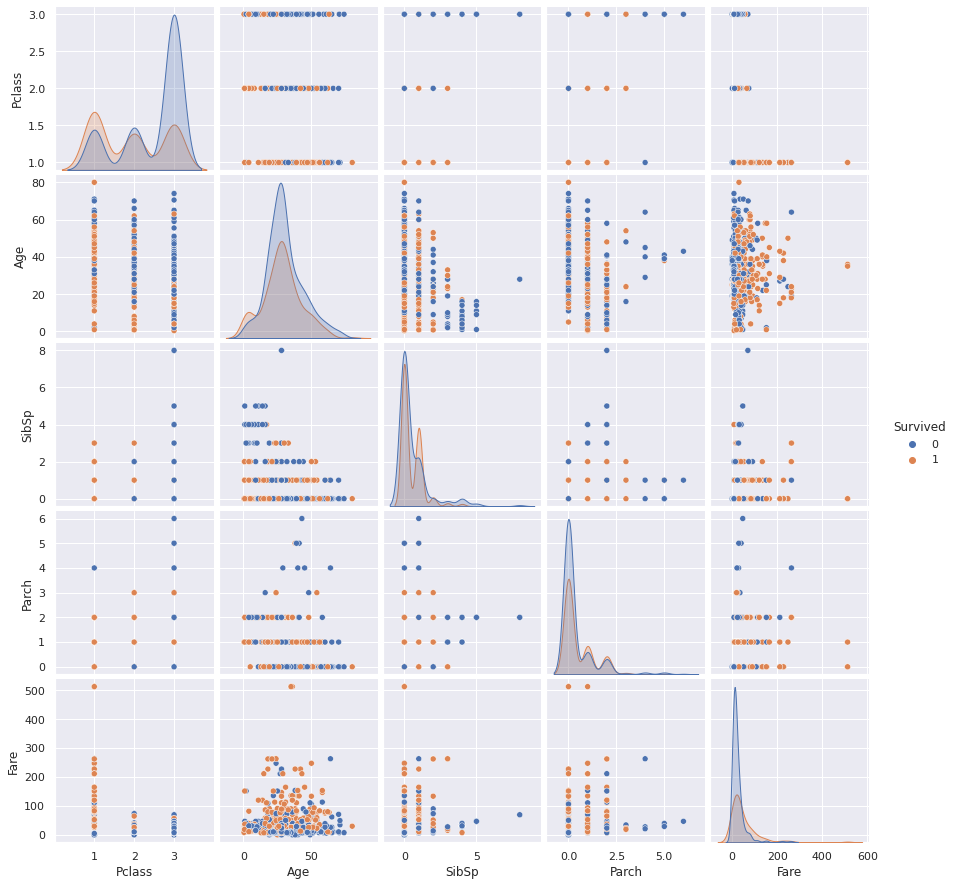

In [220]:
sns.pairplot(df, hue="Survived")

In [221]:
X = df.drop("Survived", axis=1)
y = df["Survived"]

In [222]:
X = pd.get_dummies(X, columns=["Embarked", "Sex"])

In [223]:
scaler = StandardScaler()
X[["Age", "Fare"]] = scaler.fit_transform(X[["Age", "Fare"]])

In [224]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [225]:
models = pd.DataFrame(columns=["Model", "Accuracy Score"])

In [226]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
predictions = gbc.predict(X_test)
score = accuracy_score(y_test, predictions)
print("Accuracy Score:", score)

new_row = {"Model": "GradientBoostingClassifier", "Accuracy Score": score}
models = models.append(new_row, ignore_index=True)

Accuracy Score: 0.7854077253218884


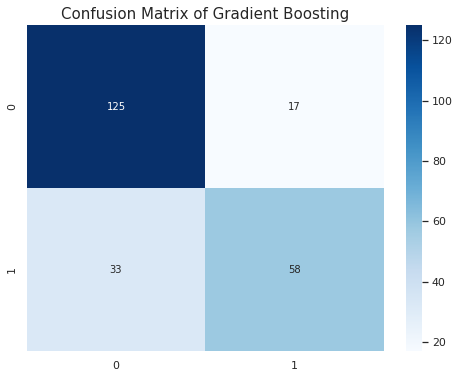

In [227]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, cmap="Blues", fmt='d')
plt.title("Confusion Matrix of Gradient Boosting", size=15)
plt.show()

ROC AUC Score: 0.852112676056338


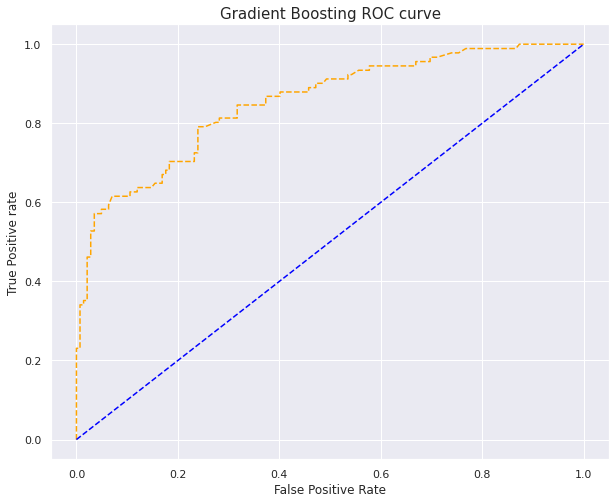

In [228]:
visualize_roc_auc_curve(gbc, "Gradient Boosting")

In [229]:
pip install shap

In [230]:
import shap

In [231]:
explainer = shap.TreeExplainer(gbc)

In [232]:
shap_values = explainer.shap_values(X)

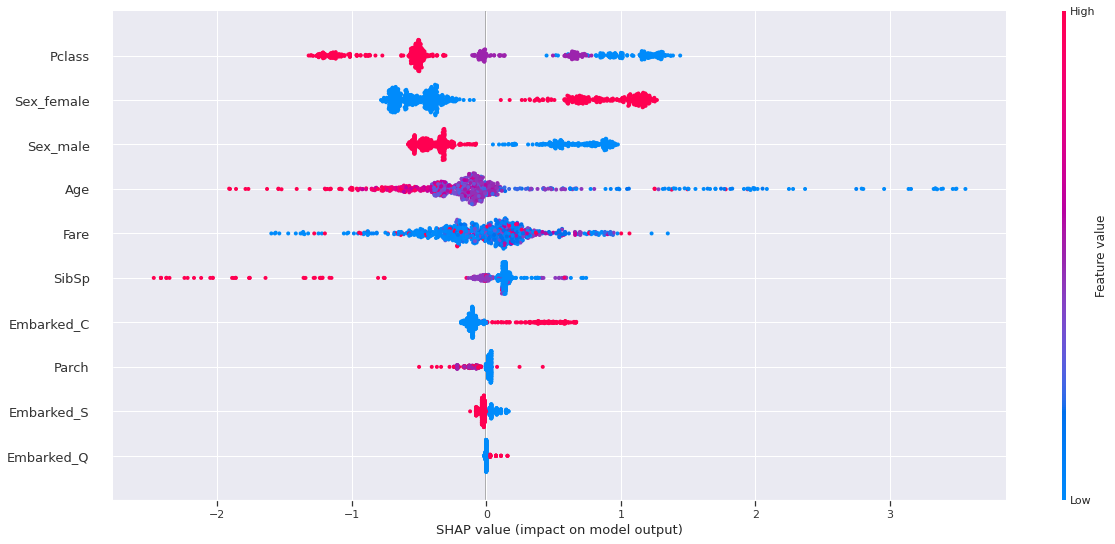

In [233]:
shap.initjs()
shap.summary_plot(shap_values, X, plot_size=(20,9))

!NB!! Если открыть документ в colab графики появятся

In [234]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[1,:], X.iloc[1,:])

In [235]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, features=X)